<a href="https://colab.research.google.com/github/KryssyCo/DS-Unit-2-Tree-Ensembles/blob/master/Krista_Shepard_DS5_S7M3_Confusion_Matrixes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment

- Read Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact, by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in this lecture notebook.

If your Kaggle Public Leaderboard score is:

- Nonexistent: You need to work on your model and submit predictions
- < 70%: You should work on your model and submit predictions

- 70% < score < 80%: You may want to work on visualizations and write a blog post
Worked on getting score over 80 on leader board and visualization.

-  If > 80%: You should work on visualizations and write a blog post

In [85]:
!pip install category_encoders

In [86]:
!pip install graphviz

In [87]:
!apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [0]:
# Import libraries
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier

In [0]:
# Import Data Set
WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Tree-Ensembles/master/data/tanzania/'
source = WEB

In [0]:
# Merge train_features.csv and train_labels.csv
train = pd.merge(pd.read_csv(source + 'train_features.csv'), 
                pd.read_csv(source + 'train_labels.csv'))

In [0]:
# Read test_features.csv and sample_submission.csv
test = pd.read_csv(source + 'test_features.csv')
sample_submission = pd.read_csv(source + 'sample_submission.csv')

In [0]:
# Split train into train and val
train, val = train_test_split(train, train_size=0.70, test_size=0.30,
                             stratify=train['status_group'], random_state=42)

In [0]:
# Function to wrangle train, validate, and test sets in the same way

def wrangle(X):
  X = X.copy()
  # Convert date_recorded to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
  #Extract components from date_recorded, then drop the original column
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')
  
  # Engineer feature: How many years from construction_year to date_recorded
  X['years'] = X['year_recorded'] - X['construction_year']
  
  #Drop recorded_by ( never varies) and id (always varies, random)
  X = X.drop(columns=['recorded_by', 'id'])
  
  # Drop duplicate columns
  duplicate_columns = ['quantity_group']
  X = X.drop(columns=duplicate_columns)
  
  # About 3% of the time, latitude has small values near zero, outside Tanzania.
  # So we treat these like null values.
  X['latitude'] = X['latitude'].replace(0, np.nan)
  
  # When columns have zeros and shouldn't they are like null values
  cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)
    
  return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of nonnumeric features

cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists
features = numeric_features + categorical_features

In [95]:
# Arrange data into X feature matrix and y target vector
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Make a pipeline!

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(max_depth=15, random_state=42)
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

#Write submission-03.csv
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-03.csv', index=False)


Validation Accuracy 0.7646464646464647


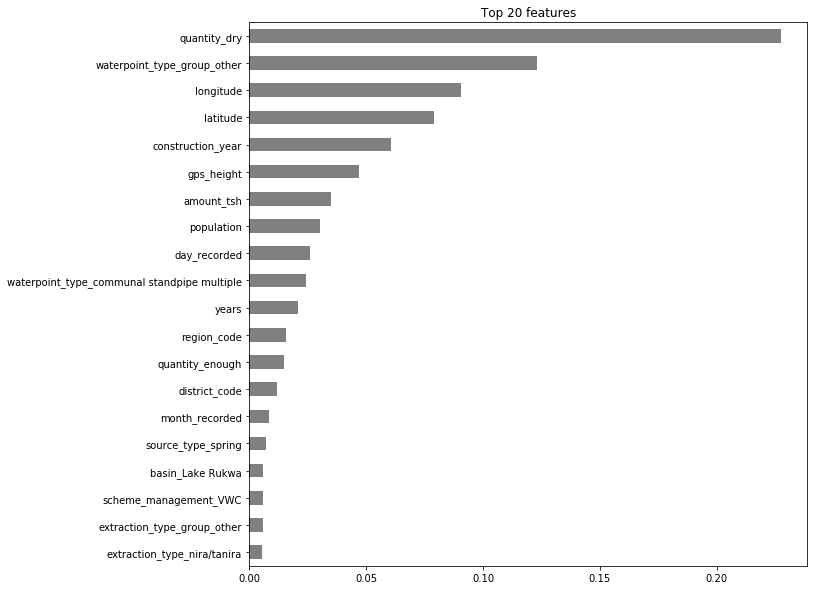

In [96]:
# Get feature importances
encoder =pipeline.named_steps['onehotencoder']
tree = pipeline.named_steps['decisiontreeclassifier']
feature_names = encoder.transform(X_val).columns
importances = pd.Series(tree.feature_importances_, feature_names)

# Plot feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

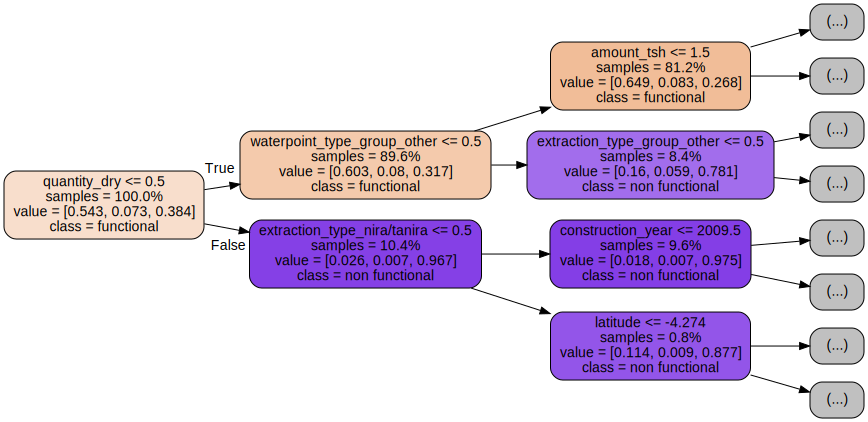

In [97]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, 
                           out_file=None, 
                           max_depth=2, 
                           feature_names=feature_names, 
                           class_names=tree.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rotate=True, 
                           rounded=True)

graphviz.Source(dot_data)

In [98]:
# Use scikit-learn for Random Forests
%%time


from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names='True'), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.807070707070707
CPU times: user 26.7 s, sys: 330 ms, total: 27.1 s
Wall time: 16.3 s


In [99]:
print('X_train shape before encoding', X_train.shape)

encoder = pipeline.named_steps['onehotencoder']
shape = encoder.transform(X_train).shape
print('X_train shape after encoding', shape)

X_train shape before encoding (41580, 33)
X_train shape after encoding (41580, 183)


In [100]:
%%time

# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8071829405162738
CPU times: user 10.6 s, sys: 111 ms, total: 10.8 s
Wall time: 6.27 s


In [0]:
y_pred = pipeline.predict(X_test)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-04.csv', index=False)

In [102]:
print('X_train shape before encoding', X_train.shape)

encoder = pipeline.named_steps['ordinalencoder']
shape = encoder.transform(X_train).shape
print('X_train shape after encoding', shape)

X_train shape before encoding (41580, 40)
X_train shape after encoding (41580, 40)


In [103]:
# First 10 rows before encoding and imputing
X_train.head(10).T

,5974,31787,27800,8008,39725,26925,41077,757,11305,59320
amount_tsh,0,0,0,0,0,0,0,0,2000,70
funder,Government Of Tanzania,Gachuma Ginery,Vwc,Government Of Tanzania,World Bank,Livin,Government Of Tanzania,Regional Water Engineer Arusha,Government Of Tanzania,Fini Water
gps_height,1410,1161,1184,NaN,1331,1854,1596,2052,1608,194
installer,DWE,GACHUMA GINERY,VWC,GOVERN,Government,Livi,DWE,REGIONAL WATER ENGINEER ARUSHA,DWE,Fini water
longitude,36.6676,33.6375,36.8546,33.024,36.528,35.057,37.4773,35.3385,30.0411,39.8099
latitude,-3.35347,-2.13916,-2.978,-2.93374,-5.67463,-8.50916,-3.28032,-3.98267,-4.60852,-10.7292
wpt_name,Kanisani,Kiwandani,Shuleni,Kwa John,Kwa Msanyi,none,Kyou,Kwa Raphael Dagharo,Kavuma,Kwa Salum Subiri
num_private,0,0,0,0,0,0,0,0,0,0
basin,Pangani,Lake Victoria,Internal,Lake Victoria,Wami / Ruvu,Rufiji,Pangani,Internal,Lake Tanganyika,Ruvuma / Southern Coast
subvillage,Inyuata,Mtakuja,Madukani,Isaka,Chapakazi,M,Kyou Kati,Harsha Kubwa,Kibimba,Mwembechai


In [104]:
# Exploring Categorical Data
train['waterpoint_type'].value_counts()

communal standpipe             19911
hand pump                      12274
other                           4480
communal standpipe multiple     4272
improved spring                  561
cattle trough                     79
dam                                3
Name: waterpoint_type, dtype: int64

In [105]:
#First 10 rows after encoding and imputing
imputer = pipeline.named_steps['simpleimputer']
X_train_encoded = encoder.transform(X_train)
X_train_imputed = imputer.transform(X_train_encoded)
pd.DataFrame(X_train_imputed, columns=X_train_encoded.columns).head(10)

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,year_recorded,month_recorded,day_recorded,years
0,0.0,1.0,1410.0,1.0,36.667568,-3.353465,1.0,0.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,200.0,1.0,1.0,1.0,1.0,2010.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2013.0,4.0,4.0,3.0
1,0.0,2.0,1161.0,2.0,33.637501,-2.139160,2.0,0.0,2.0,2.0,2.0,20.0,4.0,2.0,2.0,400.0,2.0,2.0,2.0,1.0,1996.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2013.0,1.0,16.0,17.0
2,0.0,3.0,1184.0,3.0,36.854557,-2.977996,3.0,0.0,3.0,3.0,1.0,2.0,6.0,3.0,3.0,550.0,1.0,1.0,3.0,1.0,2009.0,1.0,1.0,1.0,3.0,3.0,2.0,2.0,1.0,1.0,2.0,3.0,2.0,2.0,1.0,1.0,2013.0,3.0,14.0,4.0
3,0.0,1.0,1169.0,4.0,33.023974,-2.933736,4.0,0.0,2.0,4.0,3.0,19.0,7.0,4.0,4.0,150.0,3.0,3.0,4.0,1.0,2000.0,2.0,2.0,2.0,4.0,4.0,3.0,3.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2011.0,8.0,6.0,2011.0
4,0.0,4.0,1331.0,5.0,36.528004,-5.674631,5.0,0.0,4.0,5.0,4.0,21.0,5.0,5.0,5.0,1.0,1.0,4.0,5.0,1.0,2006.0,3.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,2.0,2.0,4.0,3.0,1.0,2.0,1.0,2013.0,2.0,18.0,7.0
5,0.0,5.0,1854.0,6.0,35.057014,-8.509156,6.0,0.0,5.0,6.0,5.0,11.0,2.0,6.0,6.0,150.0,3.0,1.0,4.0,1.0,2000.0,4.0,3.0,3.0,1.0,1.0,3.0,3.0,1.0,1.0,1.0,5.0,3.0,1.0,3.0,2.0,2011.0,3.0,5.0,11.0
6,0.0,1.0,1596.0,1.0,37.477340,-3.280316,7.0,0.0,1.0,7.0,6.0,3.0,4.0,7.0,7.0,1.0,3.0,3.0,6.0,1.0,1972.0,1.0,1.0,1.0,4.0,4.0,3.0,3.0,1.0,1.0,1.0,3.0,2.0,2.0,4.0,3.0,2013.0,3.0,19.0,41.0
7,0.0,6.0,2052.0,7.0,35.338526,-3.982670,8.0,0.0,3.0,8.0,4.0,21.0,3.0,8.0,8.0,82.0,3.0,1.0,7.0,1.0,1976.0,5.0,4.0,4.0,1.0,1.0,3.0,3.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,1.0,2013.0,2.0,1.0,37.0
8,2000.0,1.0,1608.0,1.0,30.041146,-4.608522,9.0,0.0,6.0,9.0,7.0,16.0,2.0,9.0,9.0,1.0,1.0,5.0,4.0,2.0,2002.0,1.0,1.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,4.0,2013.0,2.0,17.0,11.0
9,70.0,7.0,194.0,8.0,39.809900,-10.729232,10.0,0.0,7.0,10.0,8.0,99.0,1.0,10.0,10.0,500.0,1.0,1.0,8.0,1.0,1978.0,3.0,2.0,2.0,1.0,1.0,4.0,4.0,1.0,1.0,1.0,4.0,3.0,1.0,2.0,1.0,2013.0,2.0,24.0,35.0


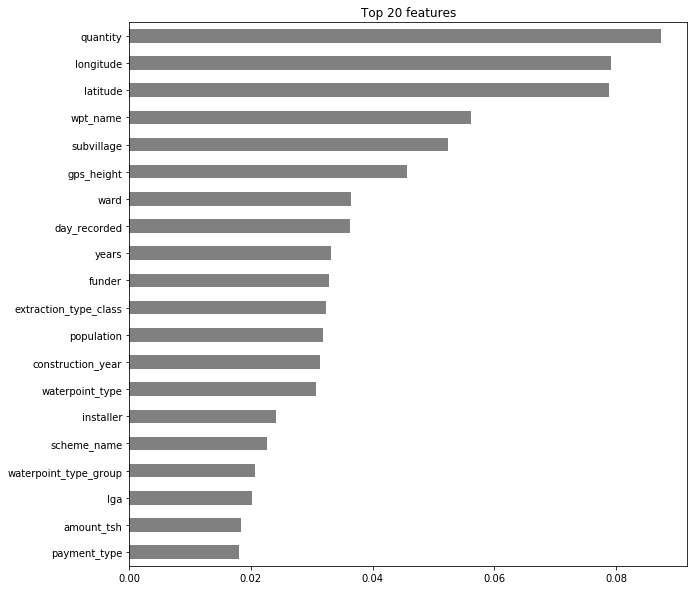

In [106]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [107]:
# Note that some of the features with the highest feature importances
# also have the highest cardinality
X_train.select_dtypes(exclude='number').nunique().sort_values(ascending=False)

wpt_name                 27265
subvillage               16078
scheme_name               2472
ward                      2073
installer                 1802
funder                    1611
lga                        124
region                      21
extraction_type             18
extraction_type_group       13
scheme_management           12
management                  12
source                      10
basin                        9
water_quality                8
extraction_type_class        7
waterpoint_type              7
payment                      7
source_type                  7
payment_type                 7
waterpoint_type_group        6
quality_group                6
management_group             5
quantity                     5
source_class                 3
permit                       2
public_meeting               2
dtype: int64

In [0]:
def viz2D(fitted_model, X, feature1, feature2, num=100, title=''):
    """
    Visualize model predictions as a 2D heatmap
    For regression or binary classification models, fitted on 2 features
    
    Parameters
    ----------
    fitted_model : scikit-learn model, already fitted
    X : pandas dataframe, which was used to fit model
    feature1 : string, name of feature 1
    feature2 : string, name of feature 2
    target : string, name of target
    num : int, number of grid points for each feature
    
    Returns
    -------
    predictions: numpy array, predictions/predicted probabilities at each grid point
    
    References
    ----------
    https://scikit-learn.org/stable/auto_examples/classification/plot_classification_probability.html
    https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html
    """
    x1 = np.linspace(X[feature1].min(), X[feature1].max(), num)
    x2 = np.linspace(X[feature2].min(), X[feature2].max(), num)
    X1, X2 = np.meshgrid(x1, x2)
    X = np.c_[X1.flatten(), X2.flatten()]
    if hasattr(fitted_model, 'predict_proba'):
        predicted = fitted_model.predict_proba(X)[:,0]
    else:
        predicted = fitted_model.predict(X)
    
    plt.imshow(predicted.reshape(num, num), cmap='viridis')
    plt.title(title)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.show()
    return predicted

In [109]:
from ipywidgets import interact
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
# Instructions
# 1. Choose two features
# 2. Run this code cell
# 3. Interact with the widget sliders
feature1 = 'population'
feature2 = 'longitude'

from sklearn.linear_model import LogisticRegression

def get_X_y(df, feature1, feature2, target):
    features = [feature1, feature2]
    X = df[features]
    y = df[target]
    X = X.fillna(X.median())
    X = ce.OrdinalEncoder().fit_transform(X)
    return X, y

def compare_models(max_depth=1, n_estimators=1):
    models = [DecisionTreeClassifier(max_depth=max_depth), 
              RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators), 
              LogisticRegression(solver='lbfgs', multi_class='auto')]
    
    for model in models:
        name = model.__class__.__name__
        model.fit(X, y)
        viz2D(model, X, feature1, feature2, title=name)

X, y = get_X_y(train, feature1, feature2, target='status_group')
interact(compare_models, max_depth=(1,6,1), n_estimators=(10,40,10));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), IntSlider(value=10, descripti…

In [0]:

from google.colab import files
files.download('submission-03.csv')

In [0]:
from google.colab import files
files.download('submission-04.csv')